Imports

In [1]:
# from win32com.client import Dispatch
from astropy import coordinates as coord, time
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Button
from IPython.display import display, clear_output
import time
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Constants
meter = 1
millimeter = 1e-3 * meter
micron = 1e-6 * meter
deg = np.pi / 180
arcsec = deg / 3600
hourangle = deg * 15
secangle = hourangle / 3600

# Location parameters
obs_lat=41.6620165; obs_lon=-91.5325033 # Iowa City
# obs_lat=31.665578; obs_lon=-110.601783 # Winer Observatory

# Telescope parameters
plate_scale = 1 / (2939 * millimeter)
pixel = 9 * micron

# Fiber parameters, large fiber used for initial search
large_fiber_diam = 1000 * micron
large_fiber_arcsec = large_fiber_diam * plate_scale / arcsec

# Actual fiber parameters for the 19 fibers
fiber_diam = 250 * micron
fiber_arcsec = fiber_diam * plate_scale / arcsec

# Single fiber (one of 19)
single_fiber_diam = 50 * micron
single_fiber_arcsec = single_fiber_diam * plate_scale / arcsec

## Connect to camera

In [ ]:
# Connect to ASCOM camera
fiber_camera = Dispatch('ASCOM.ASICamera2.Camera')

# Open setup dialog
fiber_camera.SetupDialog()

if fiber_camera.Connected:
    print('Camera is already connected')
else:
    fiber_camera.Connected = True
    if fiber_camera.Connected:
        print('Camera is connected')
    else:
        print('Camera is not connected, try again')

### Camera setup

In [ ]:
# Function to take and download image
def take_image(exposure_time):
    fiber_camera.StartExposure(exposure_time, True)
    while fiber_camera.ImageReady == False:
        time.sleep(0.1)
    img = fiber_camera.ImageArray
    img = np.array(img)
    img = np.rot90(img, 1)
    return img

In [ ]:
img = take_image(0.1)


# Plot image
plt.imshow(img, cmap='viridis')
plt.show()

value = 16
print('Number of pixels at value ', value, ': ', np.count_nonzero(img == value))

# Plot histogram of image with log scale on y-axis
plt.hist(img.ravel(), bins=256, range=(0.0, 65536.0), fc='k', ec='k')
plt.yscale('log')
plt.show()

In [ ]:
# Create widget to draw circle on image and reposition it, as well as save
# the x, y, and r values
def draw_circle(x, y, r):
    plt.imshow(img, cmap='viridis')
    circle = plt.Circle((x, y), r, color='r', fill=False)
    plt.gcf().gca().add_artist(circle)
    # Make figure larger
    plt.gcf().set_size_inches(10, 10)
    plt.show()
    return [x, y, r]

# Get max x and y dimensions from camera
max_x = fiber_camera.CameraXSize
max_y = fiber_camera.CameraYSize

circle_selector = interactive(draw_circle, x=widgets.IntSlider(min=0, max=max_x, step=1, value=max_x/2),
                               y=widgets.IntSlider(min=0, max=max_y, step=1, value=max_y/2), 
                               r=widgets.IntSlider(min=0, max=1024, step=1, value=256),
                               continuous_update=False)

In [ ]:
display(circle_selector)

In [ ]:
# Print average, median, and standard deviation of pixels in box around fiber (circle is too hard)

[fiber_x, fiber_y, fiber_r] = circle_selector.result

# Get box around fiber
fiber_box = img[fiber_y-fiber_r:fiber_y+fiber_r, fiber_x-fiber_r:fiber_x+fiber_r]

# Print average, median, and standard deviation of pixels in box around fiber
print('Average: %.2f' % np.average(fiber_box))
print('Median: %2d' % np.median(fiber_box))
print('Standard deviation: %2d' % np.std(fiber_box))

## Connect to mount

In [ ]:
telescope = Dispatch("ASCOM.PWI4.Telescope")
telescope.Connected = True

print('Coordinate system: %s' % telescope.EquatorialSystem)

Slew to source and iterate offsets to center it

In [2]:
object_name = 'Arcturus'
ra_offset = 1458 * pixel * plate_scale
dec_offset = -805 * pixel * plate_scale

obj = coord.SkyCoord.from_name(object_name)
obj_now = obj.transform_to(coord.TETE(obstime=time.Time.now(), location=coord.EarthLocation.from_geodetic(lat=obs_lat, lon=obs_lon)))
# telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle, obj_now.dec.deg + dec_offset/deg)
# telescope.Tracking = True

print('Object ICRS coordinates: %s' % obj.to_string('hmsdms'))
print('Slew coordinates: %s' % obj_now.to_string('hmsdms'))

Object ICRS coordinates: 14h15m39.6720708s +19d10m56.6729832s
Slew coordinates: 14h16m46.34034764s +19d04m27.59357747s


Compute the initial search grid from the geometry of the fiber location

Nominal deltaRA = -942.57 arcsec
Nominal deltaDec = -1755.58 arcsec


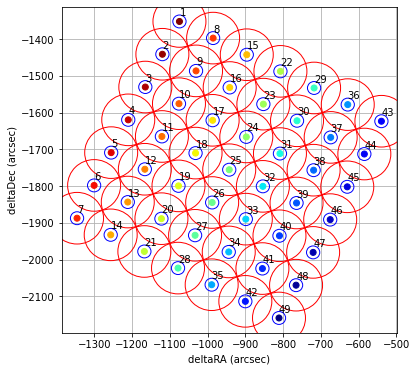

In [7]:
D = 28.047 * millimeter # 27.2 from my drawing
theta = (26.889+90) * deg

# Guess nominal ra and dec from above geometry
nominal_dec = -D * np.sin(theta) * plate_scale
nominal_ra = D * np.cos(theta) * plate_scale / np.cos(obj.dec.rad)
print('Nominal deltaRA = %.2f arcsec' % (nominal_ra / arcsec))
print('Nominal deltaDec = %.2f arcsec' % (nominal_dec / arcsec))

grid_size = 300 # Maximum offset in arcsec
grid_points = 7 # Number of points in grid

# Generate grid of deltaRA and deltaDec
delta_ras = np.linspace(-grid_size, grid_size, grid_points, endpoint=True) * arcsec
delta_decs = np.linspace(-grid_size, grid_size, grid_points, endpoint=True) * arcsec
x, y = np.meshgrid(delta_ras, delta_decs)
xrot = np.zeros(x.shape); yrot = np.zeros(y.shape)
for i in range(len(x)):
        for j in range(len(y)):
            xrot[i,j], yrot[i,j] = np.dot([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]], np.array([x[i,j], y[i,j]]))
delta_ras = xrot.flatten(); delta_decs = yrot.flatten()
delta_coords = np.array([delta_ras, delta_decs]).T

# Plot grid
fig,ax = plt.subplots(figsize=(6,6))
ax.grid(); ax.set_axisbelow(True)
ax.scatter((delta_ras+nominal_ra)/arcsec, (delta_decs+nominal_dec)/arcsec, c=range(len(delta_ras)), cmap='jet_r')
for i in range(len(delta_ras)):
    ax.annotate(str(i+1), ((delta_ras[i]+nominal_ra)/arcsec, (delta_decs[i]+nominal_dec)/arcsec), textcoords='offset points',
    xytext=(0, 6))
ax.set_xlabel('deltaRA (arcsec)')
ax.set_ylabel('deltaDec (arcsec)')
for i in range(len(delta_ras)):
    circle = plt.Circle(((nominal_ra+delta_ras[i])/arcsec, (nominal_dec+delta_decs[i])/arcsec), 
        large_fiber_arcsec, color='r', fill=False); ax.add_artist(circle)
    circle = plt.Circle(((nominal_ra+delta_ras[i])/arcsec, (nominal_dec+delta_decs[i])/arcsec),
        fiber_arcsec, color='b', fill=False); ax.add_artist(circle)
plt.show()

In [ ]:
# Make numpy array to store average, median, and standard deviation of pixels in box around fiber
# for multiple images. We will append to this array each time we take an image.
# We will use this array to plot the average, median, and standard deviation of pixels in box around fiber
# as a function of exposure time.
fiber_stats = np.empty((0, 3), float)

# On function call, take image, show image, and print average, median, and standard deviation of pixels in box around fiber
def take_image_and_print_stats(exposure_time, fiber_x, fiber_y, fiber_r, fiber_stats):
    '''Take image, plot image, and print average, median, and standard deviation of pixels in box around fiber

    Parameters:
    exposure_time (float): Exposure time in seconds
    '''
    # This is supposed to wait to clear the current output until new output is available, but it doesn't seem to work
    clear_output(wait=True) 

    # Take image, plot image
    img = take_image(exposure_time)

    # Set parameters for log stretch based on image statistics
    # Set minimum value to 1
    min_value = np.percentile(img, 5)
    # Set maximum value to 99th percentile
    max_value = np.percentile(img, 99)

    # Plot image, set log stretch
    plt.imshow(img, cmap='inferno', norm=LogNorm(vmin=min_value, vmax=max_value))
    
    # Use linear stretch
    #plt.imshow(img, cmap='inferno', vmin=min_value, vmax=max_value)
    
    # Show box around fiber
    plt.plot([fiber_x-fiber_r, fiber_x+fiber_r, fiber_x+fiber_r, fiber_x-fiber_r, fiber_x-fiber_r],
                [fiber_y-fiber_r, fiber_y-fiber_r, fiber_y+fiber_r, fiber_y+fiber_r, fiber_y-fiber_r], 'r', linewidth=1)
    # Make figure larger
    plt.gcf().set_size_inches(15, 10)
    plt.colorbar()
    plt.gcf()

    # Statistics
    [fiber_x, fiber_y, fiber_r] = circle_selector.result
    fiber_box = img[fiber_y-fiber_r:fiber_y+fiber_r, fiber_x-fiber_r:fiber_x+fiber_r]
    print('Average: %.2f' % np.average(fiber_box))
    print('Median: %2d' % np.median(fiber_box))
    print('Standard deviation: %2d' % np.std(fiber_box))

    # Append average, median, and standard deviation of pixels in box around fiber to fiber_stats
    fiber_stats = np.append(fiber_stats, [[np.average(fiber_box), np.median(fiber_box), np.std(fiber_box)]], axis=0)
    return fiber_stats

In [ ]:
for i in range(1, 10):
    fiber_stats = take_image_and_print_stats(0.001, fiber_x, fiber_y, fiber_r, fiber_stats)
    time.sleep(5)

Attempt an initial slew to the nominal guess

In [ ]:
telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + nominal_ra/hourangle, 
    obj_now.dec.deg + dec_offset/deg + nominal_dec/deg)

Grid search

In [ ]:
print('Object Coordinates: %s\n\n' % obj_now.to_string('hmsdms'))

for i in range(len(delta_coords)):
    print('Coordinate Pair %i/%i' % ((i+1), len(delta_coords)))
    print('deltaRA     =     %.2f arcsec,  deltaDec = %.2f arcsec' % ((delta_coords[i][0] + nominal_ra) / arcsec, (delta_coords[i][1] + nominal_dec) / arcsec))
    print('Slew Coordinates: %s\n' % coord.SkyCoord(obj.ra.hour + delta_ras[i]/hourangle, obj.dec.deg + delta_decs[i]/deg, unit=('hour', 'deg')).to_string('hmsdms'))
    telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + nominal_ra/hourangle + delta_coords[i][0]/hourangle, obj_now.dec.deg + dec_offset/deg + nominal_dec/deg + delta_coords[i][1]/deg)
    input('Press Enter to continue...\n')

Coordinate Pair 27/49
deltaRA     =     -1033.02 arcsec,  deltaDec = -1933.96 arcsec
Slew Coordinates: 14h15m33.64189096s +19d07m58.29610832s

Slew to best position

In [4]:
best_position = 27
print('Best position: %i' % best_position)
print('deltaRA = %.2f arcsec, deltaDec = %.2f arcsec' % ((delta_ras[best_position-1] + nominal_ra) / arcsec, (delta_decs[best_position-1] + nominal_dec) / arcsec))

#telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + delta_ras[best_position-1]/hourangle, obj_now.dec.deg + dec_offset/deg + delta_decs[best_position-1]/deg)

Best position: 27
deltaRA = -1033.02 arcsec, deltaDec = -1933.96 arcsec


Generate new grid around best position

Nominal deltaRA = -1069.20 arcsec
Nominal deltaDec = -2005.31 arcsec


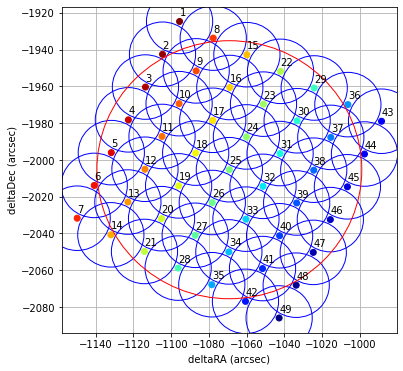

In [10]:
# Set nominal position to best fit from above grid
nominal_ra = delta_ras[best_position-1] + nominal_ra
nominal_dec = delta_decs[best_position-1] + nominal_dec
print('Nominal deltaRA = %.2f arcsec' % (nominal_ra / arcsec))
print('Nominal deltaDec = %.2f arcsec' % (nominal_dec / arcsec))

# Generate grid of deltaRA and deltaDec
delta_ras = np.linspace(-60, 60, 7, endpoint=True) * arcsec
delta_decs = np.linspace(-60, 60, 7, endpoint=True) * arcsec
x, y = np.meshgrid(delta_ras, delta_decs)
xrot = np.zeros(x.shape); yrot = np.zeros(y.shape)
for i in range(len(x)):
        for j in range(len(y)):
            xrot[i,j], yrot[i,j] = np.dot([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]], np.array([x[i,j], y[i,j]]))
delta_ras = xrot.flatten(); delta_decs = yrot.flatten()

# Plot grid
fig,ax = plt.subplots(figsize=(6,6))
ax.grid(); ax.set_axisbelow(True)
ax.scatter((delta_ras+nominal_ra)/arcsec, (delta_decs+nominal_dec)/arcsec, c=range(len(delta_ras)), cmap='jet_r')
for i in range(len(delta_ras)):
    ax.annotate(str(i+1), ((delta_ras[i]+nominal_ra)/arcsec, (delta_decs[i]+nominal_dec)/arcsec), textcoords='offset points',
    xytext=(0, 6))
ax.set_xlabel('deltaRA (arcsec)')
ax.set_ylabel('deltaDec (arcsec)')
for i in range(len(delta_ras)):
    '''circle = plt.Circle(((nominal_ra+delta_ras[i])/arcsec, (nominal_dec+delta_decs[i])/arcsec), 
        70, color='r', fill=False); ax.add_artist(circle)'''
    circle = plt.Circle(((nominal_ra+delta_ras[i])/arcsec, (nominal_dec+delta_decs[i])/arcsec),
        fiber_arcsec, color='b', fill=False); ax.add_artist(circle) 
# Plot large fiber on center position
circle = plt.Circle((nominal_ra/arcsec, nominal_dec/arcsec),
    large_fiber_arcsec, color='r', fill=False); ax.add_artist(circle)
plt.show()

Attempt an initial slew to the nominal guess

In [ ]:
telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + nominal_ra/hourangle, 
    obj_now.dec.deg + dec_offset/deg + nominal_dec/deg)

Grid search

In [ ]:
print('Object Coordinates: %s\n\n' % obj_now.to_string('hmsdms'))

for i in range(len(delta_coords)):
    print('Coordinate Pair %i/%i' % ((i+1), len(delta_coords)))
    print('deltaRA     =     %.2f arcsec,  deltaDec = %.2f arcsec' % ((delta_coords[i][0] + nominal_ra) / arcsec, (delta_coords[i][1] + nominal_dec) / arcsec))
    print('Slew Coordinates: %s\n' % coord.SkyCoord(obj.ra.hour + delta_ras[i]/hourangle, obj.dec.deg + delta_decs[i]/deg, unit=('hour', 'deg')).to_string('hmsdms'))
    telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + nominal_ra/hourangle + delta_coords[i][0]/hourangle, obj_now.dec.deg + dec_offset/deg + nominal_dec/deg + delta_coords[i][1]/deg)
    input('Press Enter to continue...\n')

Slew to best position

In [ ]:
best_position = 23
print('Best position: %i' % best_position)
print('deltaRA = %.2f arcsec, deltaDec = %.2f arcsec' % ((delta_ras[best_position-1] + nominal_ra) / arcsec, (delta_decs[best_position-1] + nominal_dec) / arcsec))

telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + delta_ras[best_position-1]/hourangle, obj_now.dec.deg + dec_offset/deg + delta_decs[best_position-1]/deg)

In [ ]:
# Make a button to get next coordinate pair and slew telescope to those coordinates
coord_index = 0

button = Button(description='Next Coordinate Pair')
display(button)
print('Object Coordinates: %s\n\n' % obj.to_string('hmsdms'))

def on_button_clicked(b):
    global coord_index

    clear_output()
    display(button)
    print('Object Coordinates: %s\n\n' % obj.to_string('hmsdms'))
    print('Coordinate Pair %i/%i' % ((coord_index+1), len(delta_coords)))
    print('deltaRA     =     %.2f sec,  deltaDec = %.2f arcsec' % (delta_coords[coord_index][0] / secangle, delta_coords[coord_index][1] / arcsec))
    print('Slew Coordinates: %s\n' % coord.SkyCoord(obj.ra.hour + delta_coords[coord_index][0]/hourangle, obj.dec.deg + delta_coords[coord_index][1]/deg, unit=('hour', 'deg')).to_string('hmsdms'))
    telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + delta_coords[coord_index][0]/hourangle, obj_now.dec.deg + dec_offset/deg + delta_coords[coord_index][1]/deg)
    coord_index += 1

button.on_click(on_button_clicked)

